#### Audio Classification Data Preprocessing

In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import normalize
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, layers
import tensorflow as tf
import gc

In [2]:
df=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
df.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [3]:
len(df)

8732

In [4]:
df['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [5]:
#Resample the dataframe to reduce memory load in training
df=df.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.2))
df['class'].value_counts()

air_conditioner     200
children_playing    200
dog_bark            200
drilling            200
engine_idling       200
jackhammer          200
street_music        200
siren               186
car_horn             86
gun_shot             75
Name: class, dtype: int64

In [6]:
df=df.reset_index()
df.drop('index',axis=1,inplace=True)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,50901-0-1-1.wav,50901,9.521096,13.521096,1,1,0,air_conditioner
1,177729-0-0-89.wav,177729,44.500000,48.500000,2,7,0,air_conditioner
2,63724-0-0-10.wav,63724,5.000000,9.000000,2,6,0,air_conditioner
3,189023-0-0-13.wav,189023,6.500000,10.500000,1,2,0,air_conditioner
4,151977-0-0-9.wav,151977,4.966587,8.966587,1,1,0,air_conditioner


[9.8192591e-05 1.6718647e-03 3.1097464e-03 ... 4.6043145e-03 4.8827445e-03
 5.3228470e-03]
22050


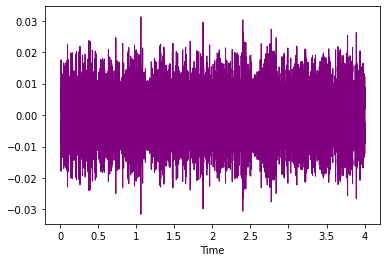

In [13]:
sample_num=150 #pick a file to display
filename=df.slice_file_name[sample_num]
#define the times of the signal
tstart = df.start[sample_num] 
tend = df.end[sample_num] #define the end time of the signal
path='UrbanSound8K/audio/fold'+str(df.fold[sample_num])+str('/'+filename)
librosa_audio_data,librosa_sample_rate=librosa.load(path) #load the file
print(librosa_audio_data)
print(librosa_sample_rate)
librosa.display.waveshow(librosa_audio_data,sr=librosa_sample_rate, x_axis='time', color='purple')
ipd.Audio(librosa_audio_data,rate=librosa_sample_rate)

In [8]:
librosa_audio_data.shape

(88200,)

In [9]:
#Calculate the average length of each audio file
df['length']=df['end']-df['start']

In [10]:
df['length'].value_counts()

4.000000    1352
4.000000      31
4.000000      20
4.000000      15
4.000000      12
            ... 
0.749977       1
1.083105       1
3.006838       1
1.313770       1
3.617655       1
Name: length, Length: 300, dtype: int64

In [11]:
df.loc[df['length']<4.000]

,slice_file_name,fsID,start,end,salience,fold,classID,class,length
25,30204-0-0-4.wav,30204,2.286916,6.286916,1,3,0,air_conditioner,4.000000
87,151977-0-0-6.wav,151977,3.466587,7.466587,1,1,0,air_conditioner,4.000000
96,30204-0-0-7.wav,30204,3.786916,7.786916,1,3,0,air_conditioner,4.000000
190,170245-0-0-0.wav,170245,0.000000,2.389546,1,5,0,air_conditioner,2.389546
200,185436-1-1-0.wav,185436,84.795657,85.786591,2,5,1,car_horn,0.990934
...,...,...,...,...,...,...,...,...,...
1520,28426-8-2-0.wav,28426,10.765795,14.383450,2,5,8,siren,3.617655
1524,165166-8-0-0.wav,165166,0.833454,4.833454,1,10,8,siren,4.000000
1547,115415-9-0-5.wav,115415,3.099702,7.099702,2,4,9,street_music,4.000000
1549,36263-9-0-12.wav,36263,7.476496,11.476496,2,5,9,street_music,4.000000


### A point to be noted, here is that I tested the sample rates for multiple audio files and it seems all of them have a S.R of 22050. Also, each file is 4s long on average. So the number of MFCC's extracted is approx between 172 and 173

#### Observation
Scipy wav reads a file as stereo,unlike librosa

In [12]:
### Lets read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(path) 

In [13]:
wave_audio

array([[-701, 1111],
       [-597, 1137],
       [-558, 1110],
       ...,
       [-767,  618],
       [-752,  609],
       [-725,  584]], dtype=int16)

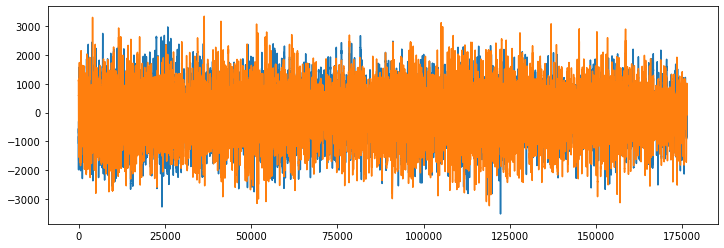

In [14]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

### Just going to extract multiple features for experimentation, before that, define a padding function to make sure that each feature axis has the same dimensionality

In [15]:
#Padding code picked up from stackoverflow, Nicolas Gervais 
#https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

### Examples of feature extraction

In [16]:
print(librosa.feature.zero_crossing_rate(librosa_audio_data))

[[0.06103516 0.07470703 0.08496094 0.05957031 0.04443359 0.0390625
  0.04931641 0.05615234 0.05517578 0.07568359 0.06396484 0.05664062
  0.05712891 0.03613281 0.03466797 0.03613281 0.04492188 0.04833984
  0.0546875  0.06640625 0.06835938 0.06591797 0.08837891 0.10449219
  0.13671875 0.14355469 0.125      0.10546875 0.06787109 0.06982422
  0.078125   0.06835938 0.07226562 0.0859375  0.07080078 0.06787109
  0.06884766 0.04394531 0.04394531 0.04931641 0.04736328 0.05273438
  0.05810547 0.06933594 0.06103516 0.06298828 0.08837891 0.10595703
  0.12353516 0.11669922 0.09375    0.07861328 0.06445312 0.06445312
  0.07128906 0.05810547 0.06152344 0.07080078 0.05322266 0.04980469
  0.04199219 0.03417969 0.03564453 0.03564453 0.03466797 0.03125
  0.03271484 0.03466797 0.03759766 0.04101562 0.04101562 0.03808594
  0.03417969 0.03076172 0.03076172 0.02783203 0.03076172 0.03125
  0.02783203 0.02978516 0.02880859 0.03173828 0.03466797 0.03466797
  0.03320312 0.03027344 0.02587891 0.02490234 0.0253906

In [17]:
mfccs = padding(librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_fft=128, hop_length=128,n_mfcc=345),1,1)
print(mfccs)
print(mfccs.shape)

[[-773.30914   -793.65094   -790.6524    ... -822.7538    -803.60034
  -825.7638   ]
 [ -35.123085   -16.614485   -16.593264  ...   10.614101    -3.55596
   -11.507282 ]
 [ -53.434223   -51.899513   -48.92108   ...  -41.859726   -32.391777
   -39.888176 ]
 ...
 [  -4.4176617   -2.6417427   -4.549963  ...   -1.87045     -4.4099045
    -4.358369 ]
 [  -6.9559975   -8.63072     -6.0838337 ...   -7.107052    -4.9649925
    -5.3738194]
 [   5.5036316    6.7441044    4.8186626 ...    4.9097323    3.5590627
     4.0946856]]
(128, 690)


[[6.3144028e-01 5.8693057e-01 6.5640098e-01 ... 3.8632822e-01
  9.5184511e-01 1.3966799e-01]
 [5.2994937e-01 5.8229196e-01 2.7926156e-01 ... 4.4376338e-01
  8.4424424e-01 1.0288811e-01]
 [2.8989145e-01 3.7460959e-01 4.0694958e-01 ... 2.9334903e-01
  5.3891659e-01 2.8849304e-02]
 ...
 [3.9040856e-04 4.3463504e-05 7.0601031e-06 ... 1.1751167e-04
  4.2848093e-05 8.8252372e-04]
 [2.8725306e-04 1.1463894e-05 1.0908220e-05 ... 1.2712264e-05
  3.2510407e-06 8.5956370e-04]
 [2.4368217e-04 5.3191843e-06 1.0760626e-05 ... 1.1848424e-08
  2.6518845e-07 8.4894459e-04]]
(65, 690)


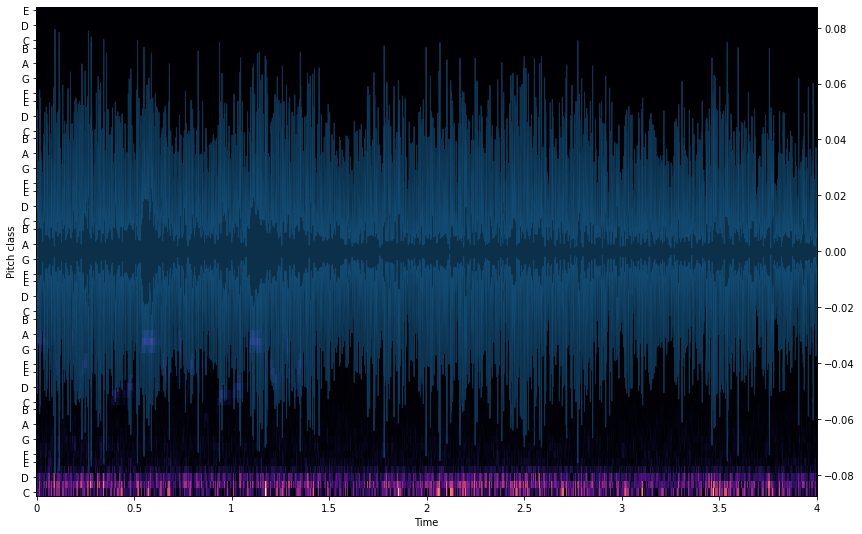

In [18]:
stft = padding(np.abs(librosa.stft(librosa_audio_data, n_fft=128, hop_length= 128)), 18, 1)
print(stft)
print(stft.shape)
fig = plt.figure(figsize=(14, 9))
ax1 = fig.subplots()
ax2 = ax1.twinx()

librosa.display.specshow(stft, x_axis='time', y_axis='chroma', ax=ax1,n_fft=128, hop_length= 128)
librosa.display.waveshow(librosa_audio_data, sr=librosa_sample_rate, ax=ax2,alpha=0.4)
plt.show()

In [19]:
#Defined a custom normalizer to visualize spectral centroids against the waveform
def normalizer(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)*0.4

(173,)


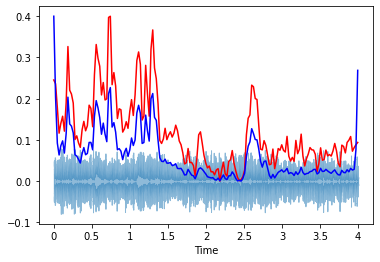

In [20]:
spec_centroid = librosa.feature.spectral_centroid(librosa_audio_data, sr=librosa_sample_rate)[0]
spec_centroid_corrected = librosa.feature.spectral_centroid(librosa_audio_data+0.08, sr=librosa_sample_rate)[0]
print(spec_centroid_corrected.shape) #1,173
librosa.display.waveshow(librosa_audio_data, sr=librosa_sample_rate,alpha=0.5)
frames = range(len(spec_centroid))
t=librosa.frames_to_time(frames)
plt.plot(t,normalizer(spec_centroid), color='r')
plt.plot(t,normalizer(spec_centroid_corrected), color='b')
plt.show()

#TThe blue line seems to be more tolerant to sudden dips. Hence we will add 0.08 into the spectral centroid plot

(12, 690)


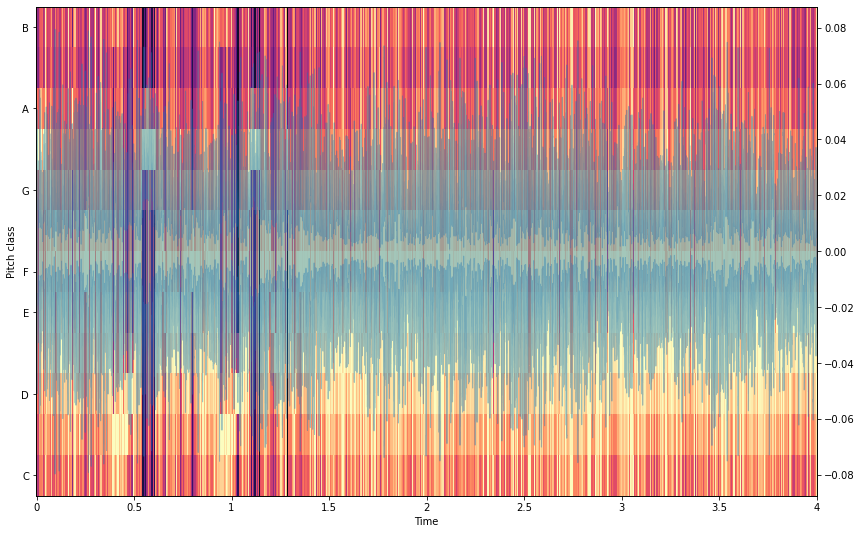

In [21]:
chroma_stft=librosa.feature.chroma_stft(y=librosa_audio_data, sr=librosa_sample_rate, n_fft=128, hop_length= 128)
print(chroma_stft.shape)
fig = plt.figure(figsize=(14, 9))
ax1 = fig.subplots()
ax2 = ax1.twinx()
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', ax=ax1, n_fft=128, hop_length= 128)
librosa.display.waveshow(librosa_audio_data, sr=librosa_sample_rate, ax=ax2,alpha=0.4)
plt.show()

(2, 173)


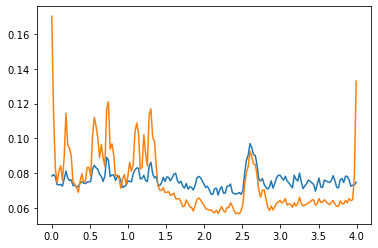

In [22]:
#What would spec_bw and centroid together look like?
spec_centroid_corrected = librosa.feature.spectral_centroid(librosa_audio_data+0.08, sr=librosa_sample_rate)
spec_bw=librosa.feature.spectral_bandwidth(librosa_audio_data, sr=librosa_sample_rate,centroid=spec_centroid_corrected)
image = np.array(normalize(spec_bw))
image = np.append(image,normalize(spec_centroid_corrected), axis=0)
print(image.shape)
frames = range(len(spec_bw[0]))
t=librosa.frames_to_time(frames)
plt.plot(t,np.transpose(image))

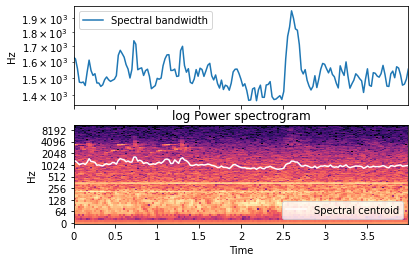

In [23]:
S, phase = librosa.magphase(librosa.stft(y=librosa_audio_data))
sr=librosa_sample_rate
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=S)
spec_bw=librosa.feature.spectral_bandwidth(librosa_audio_data, sr=librosa_sample_rate)
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
# ax[1].fill_between(t, np.maximum(0, spec_centroid - spec_bw),
#                 np.minimum(centroid[0] + spec_bw[0], sr/2),
#                 alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

### It does seem especially important to merge all this features along the Z axis so that they show a better depiction

# Actual feature extraction

### It might make sense to depth stack our earlier observed features so that our model can utilize all 4 of them

In [24]:
sr=librosa_sample_rate
def generate_features(y_cut):
    max_size=1000 #an attempt to conserve computing resources
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=128, hop_length= 128)), 128, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=128, hop_length=128,n_mfcc=690),128,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut+0.08, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr, n_fft=128, hop_length= 128)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr,centroid=spec_centroid)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),1, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image
    

In [25]:
generate_features(librosa_audio_data).shape

(128, 1000, 3)

In [61]:
data=generate_features(librosa_audio_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


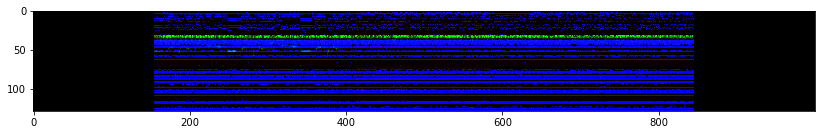

In [62]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 25))
plt.imshow(data, interpolation='nearest')
plt.show()

### Let's just get the above stated features for each audio file

In [26]:
def get_features(df_in):
    output=[]
    labels = []
#     df_in=df_in.reset_index()
    for i in df_in['class'].unique():
        print('class:',i)     #all the file indices with the same species_id     
        filelist = df_in.loc[df['class']==i].index         
        for j in range(0,len(filelist)):             
            filename = df_in.iloc[filelist[j]].slice_file_name #get the filename   
            #define the timestamps of the signal          
            tstart = df_in.iloc[filelist[j]].start
            tend = df_in.iloc[filelist[j]].end 
            fold = df_in.iloc[filelist[j]].fold
            class_id=i
            #Load the file
            y, sr = librosa.load('UrbanSound8K/audio/fold'+str(str(fold)+str('/'+filename)))  
            #cut the file to signal start and end  
            y_cut=y[int(round(tstart*sr)):int(round(tend*sr))]  
            #generate features & output numpy array          
            data = generate_features(y_cut) 
#             features.append(data[np.newaxis,:])    
            labels.append(class_id)  
            output.append(data)
    return(output, labels)

In [27]:
#Now we can pass the appropriate dataframe and get the said features
extracted_features_list,extracted_labels_list=get_features(df)

class: air_conditioner
class: car_horn
class: children_playing
class: dog_bark
class: drilling
class: engine_idling
class: gun_shot
class: jackhammer
class: siren
class: street_music


In [28]:
extracted_features_list[1000].shape

(128, 1000, 3)

In [29]:
df_ext=pd.DataFrame(columns=['feature','labels'])

In [30]:
df_ext['feature']=extracted_features_list
df_ext['labels']=extracted_labels_list

In [31]:
df_ext.head()

,feature,labels
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner
4,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner


In [32]:
#Clear the list variables to save memory
del extracted_features_list
del extracted_labels_list
gc.collect()

32897

In [33]:
### Split the dataset into independent and dependent dataset
X=np.array(df_ext['feature'].tolist())
y=np.array(df_ext['labels'].tolist())

In [34]:
#Destruct the new dataframe variable()
del df_ext
gc.collect()

0

In [35]:
X.shape

(1747, 128, 1000, 3)

In [36]:
y.shape

(1747,)

### Final frontier before training, convert the class feature into labels

In [37]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
y.shape

(1747, 10)

In [38]:
### Train Test Split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)

In [39]:
X_train.shape

(1397, 128, 1000, 3)

In [40]:
y_train.shape

(1397, 10)

In [41]:
X_test.shape

(350, 128, 1000, 3)

In [42]:
y_test.shape

(350, 10)

In [43]:
#Destruct the X array to declutter
del X
gc.collect()

0

In [76]:
X_train.min()

0.0

# CNN


In [44]:
#Data normalization
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [67]:
del CNNmodel
gc.collect()

33942

In [69]:
keras.backend.clear_session()
input_shape=(128,1000,3)
CNNmodel = models.Sequential()
#First layer
CNNmodel.add(layers.Conv2D(32, (2,2), activation='relu',padding='same',input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2)))
CNNmodel.add(layers.Dropout(0.2))
#Second layer
CNNmodel.add(layers.Conv2D(64, (2,2),padding='same',activation='relu'))
CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2)))
CNNmodel.add(layers.Dropout(0.2))
#Third layer
CNNmodel.add(layers.Conv2D(32, (2,2),padding='same', activation='relu'))
CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2)))

CNNmodel.add(layers.Flatten())

#Fourth layer
CNNmodel.add(layers.Dense(256, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
#Fifth layer
CNNmodel.add(layers.Dense(32, activation='relu'))
#Final layer
CNNmodel.add(layers.Dense(10, activation='softmax'))

In [70]:
CNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 1000, 32)     416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 500, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 500, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 500, 64)       8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 250, 64)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 250, 64)       0

In [71]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_CNN.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

CNNmodel.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\Admin\anaconda3\envs\audio\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Admin\anaconda3\envs\audio\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Admin\anaconda3\envs\audio\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Admin\anaconda3\envs\audio\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Admin\anaconda3\envs\audio\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8904\1232568058.py", line 11, in <cell line: 11>
      CNNmodel.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\Admin\anaconda3\envs\audio\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_1607]

In [ ]:
history = CNNmodel.fit(X_train, y_train, epochs=20, validation_data= (X_val, y_val))